<a href="https://colab.research.google.com/github/prachi-khandelwal/Dog-Vision-MultiClassification-Project/blob/master/end_to_end_dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐶End-To-End MultiClass Dog Breed Identification

this Notebook builds an end-to-end multi-class image classifier using TensolrFlow 2.0 and Tensorflow Hub.

## 1. Problem

Identifying the breed of the dog given in the image of a dog.

When I am roaming around in my locality a dog passed and I wanted to Know the breed of the dog.😊😁

## 2. Data

The Data we're using is from Kaggle's Dog Breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is the file with Prediction Probabilitiesfor each dog breed in the image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation
## 4. Features

Some Information about the Data:
* We're dealing with images (unstructured Data) so its probably best to use Deep learning /Transfer Learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10K images in Trainng set (These Images have Labels).
* There are around 10k images in Test set (These Images don't have labels).





In [92]:
# Unzip the data into Google Drive.
# !unzip "/content/drive/My Drive/Dog vision/dog-breed-identification.zip" -d "drive/My Drive/Dog vision"

# Get our Workspace Ready!
* Import Tensorflow 2.x ✅
* Import TensorFlow Hub✅
* Make sure we're using a GPU 


Import necessary Tools

In [93]:
# Import TensorFlow into COlAB
import tensorflow as tf
print("Tensorflow version:",tf.__version__)
# Import Tensorflow HUB
import tensorflow_hub as hub
print("Tensorflow hub version:",hub.__version__)

Tensorflow version: 2.2.0
Tensorflow hub version: 0.8.0


In [94]:
# Check If a GPU available
print("GPU", "available YEP!" if tf.config.list_physical_devices("GPU") else "not available :( ")

GPU available YEP!


## Getting our Data ready! (turning into tensors)
With all ML models our data must be in numerical format. So that's what we're going to do.
Turning our images into tensors(Numerical Representation)

Let's start by accessing our data and checking labels



In [95]:
# Checkout the data labels
import pandas as pd
import numpy as np
labels_csv = pd.read_csv("drive/My Drive/Dog vision/labels.csv")
print(labels_csv.describe())
labels_csv.head()

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     e237f2c2da59abcb4d622106db8eef11  scottish_deerhound
freq                                   1                 126


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [96]:
labels_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [97]:
# Let's see the no. of images of each breed
labels_csv["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
komondor                 67
brabancon_griffon        67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

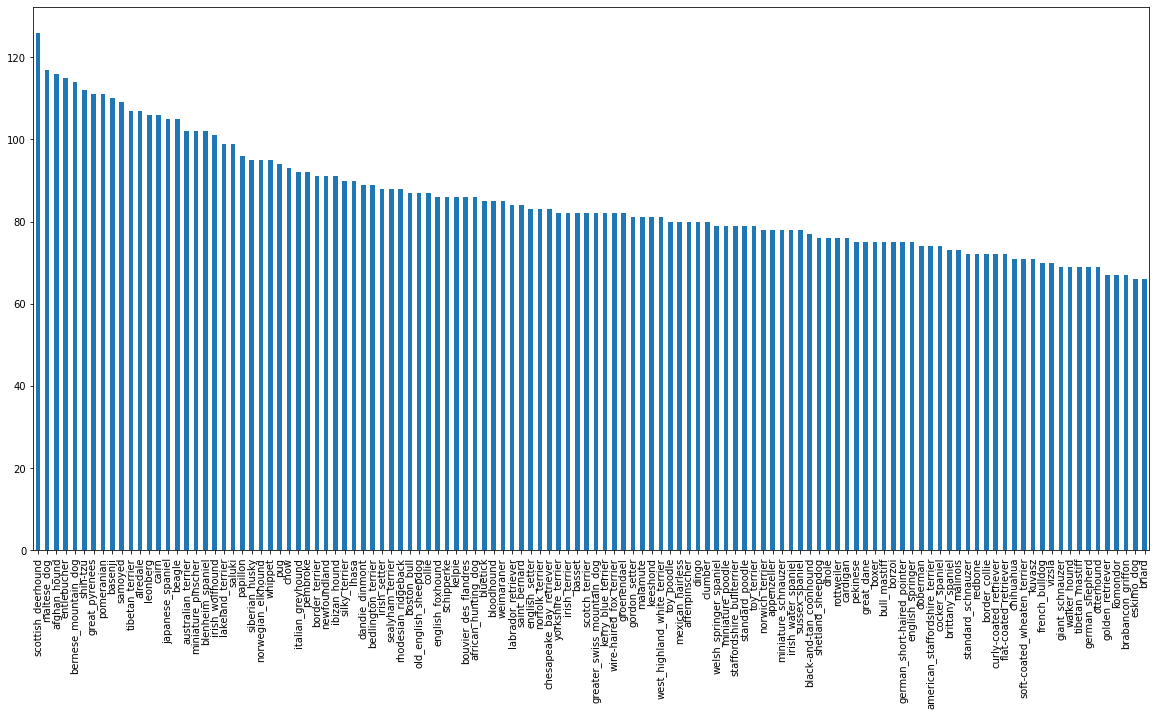

In [98]:
# let's visualize it
ax = labels_csv["breed"].value_counts().plot.bar(figsize=(20,10));

In [99]:
# To display the Images
from IPython.display import display, Image
# Image("drive/My Drive/Dog vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

## Getting Images and their labels
Let's get list of our images file Pathnames

In [100]:

# Create filenames from ID
filenames = ["drive/My Drive/Dog vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]
filenames[:10]

['drive/My Drive/Dog vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [101]:
# Checking whether the number of filenames mathcing to the actual images files in train folder
import os
if len(os.listdir("drive/My Drive/Dog vision/train/")) == len(filenames):
  print("Number of files Matched Proceed!")
else:
  print("Files Not Matched Erorr!")
  
  

Number of files Matched Proceed!


### Since Now we've got our FilePath ready, let's prepare our labels

In [102]:
labels = labels_csv['breed'].to_numpy()  #to_numpy() converts into numpy array
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [103]:
len(labels)

10222

In [104]:
#let's see if number of labels matches number of filenames
if len(labels) == len(filenames):
  print("No. of Labels Matches No. of Filenames! Proceed.")
else:
  print("Check Again! Labels does't matches Filenames")


No. of Labels Matches No. of Filenames! Proceed.


In [105]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [106]:
# turn single label into an array
print(labels[1])
labels[1] == unique_breeds

dingo


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [107]:
# Turn every label into a Boolean Array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [108]:
len(boolean_labels)

10222

## Turning **Boolean Labels into Integers**

In [109]:
print(labels[1]) #Original Label
print(np.where(unique_breeds == labels[1])) #index where label occur in unique_breeds 
print(boolean_labels[1].argmax()) #argmax returns max value in the array
print(boolean_labels[1].astype(int)) #converts boolean values into Int

dingo
(array([37]),)
37
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


## Creating our own Validation set
Since kaggle doesn't provide any validation set.

In [110]:
# Setup X and Y variables
X = filenames
y = boolean_labels

Since Experimenting with 10k images might take long, so we'll experiment with ~1000 images at first & increases as needed.

In [111]:
# Set number of images
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [112]:
# Let's split our data into train & valid sets
from sklearn.model_selection import train_test_split

# let's split our data into train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X[:NUM_IMAGES],
                                                      y[:NUM_IMAGES],
                                                      test_size=0.2,
                                                      random_state=42)
len(X_train), len(X_valid), len(y_train), len(y_valid)

(800, 200, 800, 200)

In [113]:
#Let's peek into our train and test data
X_train[:5], y_train[:2]

(['drive/My Drive/Dog vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Dog vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/My Drive/Dog vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/My Drive/Dog vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/My Drive/Dog vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, Fa

## Pre-processing of Image (Turning into Tensors)
To process our images into Tensors we're going to write a function which does few things.
1. Take Image filepath as input.
2. Use Tensorflow to read the image file and save it to a variable, `image`.
3. Turn our `image` (jpg) into Tensors.
4. Normalise our image (convert our color channel values from 0-255 to 0-1). 
5. Resize the image to be a shape of (224,224).
6. Return the modified image.

Before creating function let's peek how a tensor image look like

In [114]:
# Convert single image into numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
len(image),image

(257, array([[[ 89, 137,  87],
         [ 76, 124,  74],
         [ 63, 111,  59],
         ...,
         [ 76, 134,  86],
         [ 76, 134,  86],
         [ 76, 134,  86]],
 
        [[ 72, 119,  73],
         [ 67, 114,  68],
         [ 63, 111,  63],
         ...,
         [ 75, 131,  84],
         [ 74, 132,  84],
         [ 74, 131,  86]],
 
        [[ 56, 104,  66],
         [ 58, 106,  66],
         [ 64, 112,  72],
         ...,
         [ 71, 127,  82],
         [ 73, 129,  84],
         [ 73, 130,  85]],
 
        ...,
 
        [[  2,  11,  10],
         [  5,  14,  13],
         [  6,  15,  14],
         ...,
         [120, 113,  67],
         [126, 118,  72],
         [122, 114,  67]],
 
        [[  0,   4,   6],
         [  0,   9,   8],
         [  1,  10,   9],
         ...,
         [105,  98,  52],
         [111, 104,  58],
         [111, 103,  56]],
 
        [[ 18,  16,  37],
         [ 18,  18,  28],
         [ 17,  20,  11],
         ...,
         [101,  92,  53

In [115]:
# Convert single image into tensor
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

In [116]:
# Define image size
IMG_SIZE = 224

# Create a Function for preprocessing
def preprocess(image_path, img_size=IMG_SIZE):
  """
  Preprocess The Image and convert into tensors.
  """
  # Input the Image file path
  image = tf.io.read_file(image_path)

  # Turn the jpeg image into numerical Tensors with 3 color channel(Red, Green and Blue)
  image = tf.image.decode_jpeg(image, channels=3)

  # normalise the color channel values from 0-255 to 0-1
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the image
  image = tf.image.resize(image,[img_size, img_size])

  return image

## Turning our Data into Batches
Why turn our data into batches?
let's say if your are trying to process 10000 images at one go...

They all might not fit into memory.

So that's why we do 32(batch size) images at a time.

In order to use Tensorflow effectively, we need our data in the form of tensor tuples: `(image, label)`.



In [117]:
# Create a simple function to return a tuple
def get_image_label(image_path, label):
  """
  returns the image and label into tuple form
  """
  image = preprocess(image_path)
  return image, label

In [118]:
(preprocess(X[42]),tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now've got a way to turn our data into Tuples of Tensors in the form of `(image, label)`, Let's make a function to create Batches for our data `X` and `y`.

In [119]:
# define the batch size, 32 is good start
BATCH_SIZE = 32

# Create a Function to Turn Data into Batches
def create_data_batches(X, y, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates Batches of data out of image (X) and label (y) pairs.
  Shuffle the data if it's training data but doesn't shuffle valid data.
  Also accepts test data as input(no labels).
  """
  # If the Data is Test data, we probably don't have labels
  if test_data:
    print("Creating Test Data Batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) #Only filepaths(no label)

    data_batch = data.map(process_image).batch(BATCH_SIZE)

    return data_batch

  # If the Data is Valid data, we don't need to shuffle it
  elif valid_data:
    print("Creating Valid data batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), #Filepath
                                               tf.constant(y))) #Label

    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  # If the Data is Training data, we had to shuffle it before processing Images
  # As it will save Computation Time
  else:
    print("Creating Training Data Batches...")
    # Turn Filepaths and Labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), 
                                               tf.constant(y)))
    # Shuffling the pathnames and labels before Mapping image process function
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples, it also turns the image path into processed image
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
  return data_batch
    

In [120]:
# Creating Validation and training data BATCHES
train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_valid, y_valid, valid_data=True)

Creating Training Data Batches...
Creating Valid data batches


In [121]:
# Check out the attributes of our data Batches
train_data.element_spec, valid_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches
Our Data is in batches, this can be a liitle hard to comprehend let's visulaise our data specifically 25 Images. 

In [122]:
import matplotlib.pyplot as plt

# Create a function to visulaise batches of Images
def image_batch_visualise(image, label):
  """
  Displays a batch of 25 image batch with their labels.
  """
  # Set the figsize
  plt.figure(figsize=(10,10))
  #Set the loops to display 25 images
  for i in range(25):
     # set the axis subplots
     ax = plt.subplot(5, 5, i+1)
     # Display image
     plt.imshow(image[i])
     # Set the title over the image using label
     plt.title(unique_breeds[label[i].argmax()],{'color':'white','fontweight':'23'})
     # set the grid off
     plt.axis("off")


Now we've craeted our function to visulise the images but before that we first need to `UNBATCH` the proceesed images to visualise them.

In [123]:
train_images, train_labels = next(train_data.as_numpy_iterator())

In [124]:
len(train_images), len(train_labels)

(32, 32)

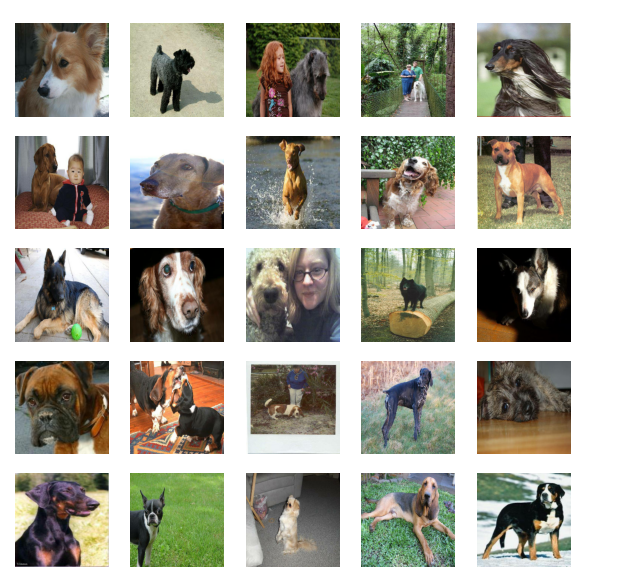

In [125]:
# Let's visualise Training batch
image_batch_visualise(train_images, train_labels)


In [126]:
# Let's visualise valid batch
valid_images, valid_labels = next(valid_data.as_numpy_iterator())



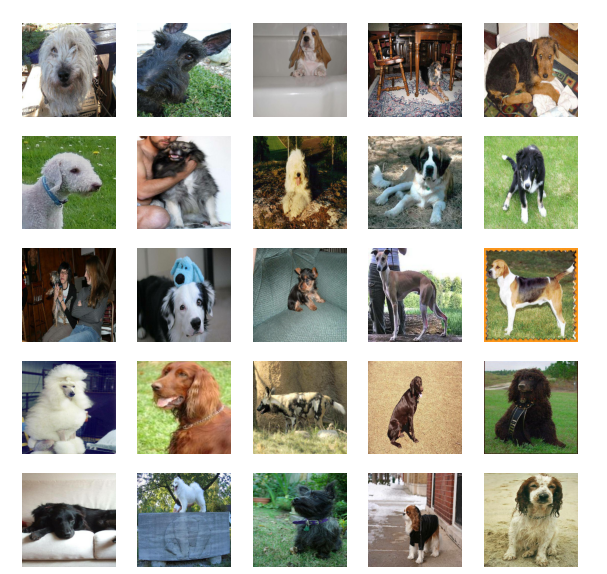

In [127]:
image_batch_visualise(valid_images, valid_labels)

# Building a Model
Before building a model we need to specify certain things to define.
1. The input shape (our image shape in the form of tensors) to our model.
2. the output shape (our image labels in the form of tensors) to our model.
3. URL of the Model which we're going to use from  Tensorflow Hub.
https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [130]:
# Setup Input shape (Images)
INPUT_SHAPE = [None, IMG_SIZE,IMG_SIZE, 3] #batch, width, height, color channel

# Setup OutPut shape (labels)
OUTPUT_SHAPE = len(unique_breeds)

# URL of TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we've input, output and our model ready to go, Let's put them together using Keras deep learning model!

Knowing this Let's create a model which does following tasks:
* Takes input, output and model we've chosen as parameters.
* Define the layers in Keras model as Sequential manner(do this, then this, then that).
* Complies the model(say evaluate and improved).
* Build the model tell it the input shape it'll be getting.
* Returns the model.





In [131]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model=MODEL_URL):
  print(" Building model with", MODEL_URL)

  #setup the model layers
  model = tf.keras.Sequential([
          hub.KerasLayer(MODEL_URL), #Layer 1 (input Layer)
          tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                                activation='softmax') #Layer 2 output layer
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model




In [132]:
model = create_model()
model.summary()

 Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________
